# Dataset1 - Adult Data Set

## Data loading and processing

Load the dataset form 'adult.data'. Convert categorical features into numbers and convert missing values into -1.

In [171]:
import numpy as np

#feature names and categorical features
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
category_features = np.array([1,3,5,6,7,8,9,13])
categories = {'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
              'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
              'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
              'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing','Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
              'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
              'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
              'sex': ['Female', 'Male'],
              'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']}
    
#Convert categorical features into numbers and convert missing values into -1.
def find_category(string, index):
    l = categories[features[index]]
    if string in l:
        return l.index(string)
    return -1

converters = {}
for i in category_features:
    def lambda_generator(i):
       return lambda s: find_category(s.strip(), i)
    converters[i] = lambda_generator(i)
converters[len(features)] = lambda s: 1 if '>50K' in s else 0

data = np.loadtxt('./adult.data', dtype=int, encoding='utf-8-sig', delimiter=', ', converters=converters)
print('The shape of the dataset is', data.shape)

The shape of the dataset is (32561, 15)


Clean the Data.

Remove instances that have 3 or more missing data entries.

Impute missing values with most frequent value of each column.

In [152]:
#clean the traing data

from sklearn.impute import SimpleImputer

#seperate X and y from data
y_train = data[:, -1]
X_train = np.delete(data, -1, axis=1)

#delete rows which contain missing data points
missing_count = np.count_nonzero(X_train == -1, axis=1)
X_train = np.delete(X_train, np.where(missing_count>2), axis=0)
y_train = np.delete(y_train, np.where(missing_count>2), axis=0)
print('The shape of the dataset after deleting is', X_train.shape)

#Impute missing values with most frequent value of each column.
imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
X_train = imp.fit_transform(X_train)

The shape of the dataset after deleting is (32534, 14)


In [153]:
#one-hot-coding
def one_hot_coding(X):
    #for each category feature, do one-hot coding
    for index in category_features:
        feature_data = X[:, index]
        one_hot = np.zeros((feature_data.size, len(categories[features[index]])), dtype=int)
        rows = np.arange(feature_data.size)
        one_hot[rows, feature_data] = 1
        X = np.concatenate((X, one_hot), axis = 1)
        
    #delete original data of category features
    X = np.delete(X, category_features, axis=1)
    return X

X_train = one_hot_coding(X_train)
print('The shape of the dataset after one-hot coding is', X_train.shape)

#feture names after one-hot coding
feature_names = np.array(features, dtype=str)
for index in category_features:
    feature_names = np.concatenate((feature_names, np.array(categories[features[index]])))
feature_names = np.delete(feature_names, category_features)

The shape of the dataset after one-hot coding is (32534, 105)


## Visualize the distribution of data.

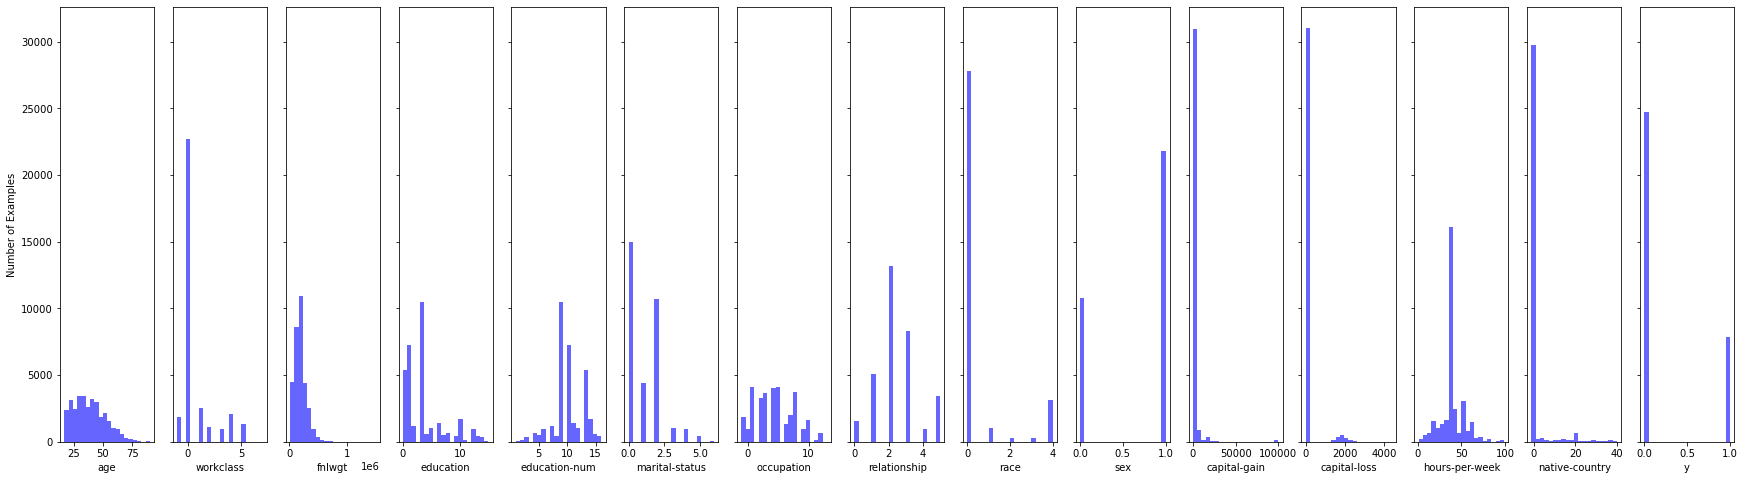

In [154]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, data.shape[1], sharey=True)
fig.set_size_inches(30, 8)
for i, ax in enumerate(axs):
    ax.hist(data[:, i], 20, facecolor='b', alpha=0.6)
    if i<len(features): ax.set_xlabel(f'{features[i]}')
    else: ax.set_xlabel(f'y')
axs[0].set_ylabel('Number of Examples')
plt.show()


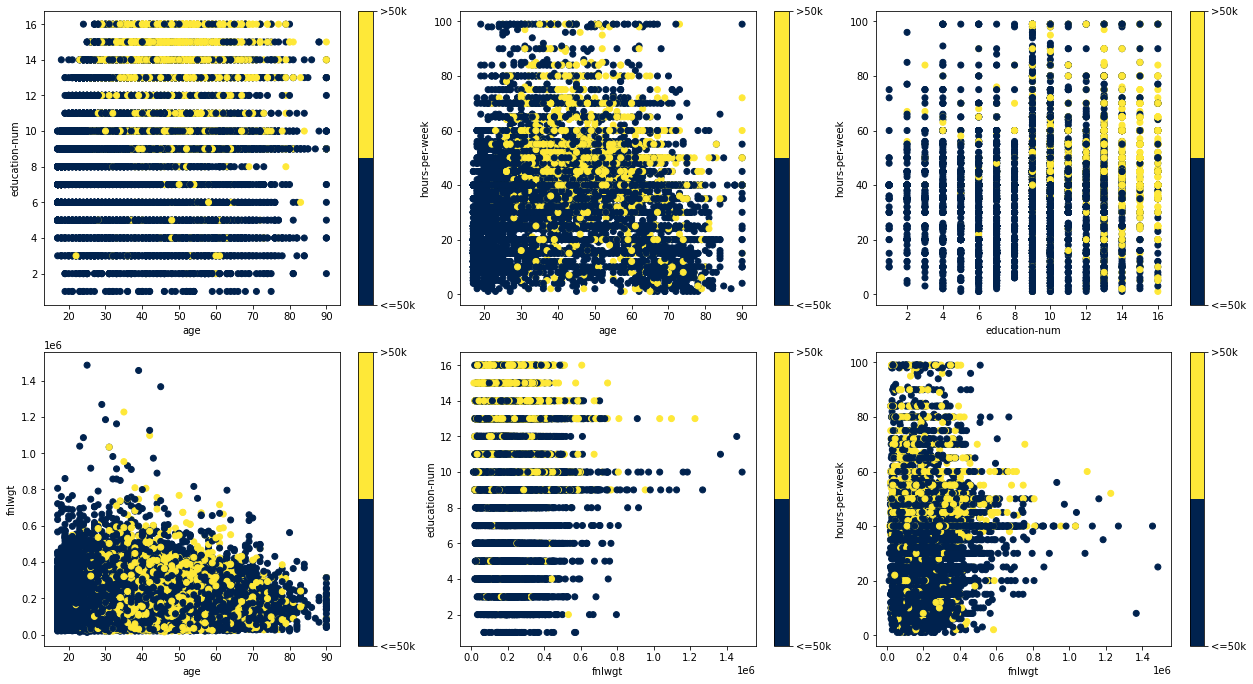

In [119]:
plt.figure(figsize=(18, 10))
for pairidx, pair in enumerate([[0,2], [0,5], [2,5], [0,1], [1,2], [1,5]]):
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    x1_index, x2_index = pair[0], pair[1]
    formatter = plt.FuncFormatter(lambda i, *args: '>50k' if i==1 else '<=50k')
    plt.scatter(X_train[:,x1_index], X_train[:,x2_index], c=y_train, cmap=plt.cm.get_cmap('cividis',2))
    plt.colorbar(ticks=[0,1], format=formatter)
    plt.xlabel(feature_names[x1_index])
    plt.ylabel(feature_names[x2_index])

## KNN

### Use 5-fold cross-validation to pick the best K value of KNN model

In [122]:
#CV implementation
def cross_validation(model, X, y, k_fold = 5):
    """
    method: cross_validation
    params: Model(object used to fit data) model
      numpy array (array-like) Data X
      numpy array (array-like) Labels y
      int k_fold (default value set to 5)
    return: A tuple containing the Model(Final Model with best accuracy) final_model and float best_accuracy - average validation accuracy
    """
    best_accuracy = 0
    start = math.ceil((X.shape[0]/k_fold)*(k_fold-1))
    end = X.shape[0]
    model_accuracies = list()

    "Mashbayar, to delete: The original method threw some weird key error, so just using the scikit implementation of the same thing"
    # shuffle the training data
    #np.random.seed(1)
    #np.random.shuffle(X)
    #np.random.seed(1)
    #np.random.shuffle(y)
    
    X, y = shuffle(X, y)

    # k_fold
    for i in range(k_fold):

        # split into training and validation data
        validation_X = X.iloc[start: end]
        validation_y = y.iloc[start: end]

        training_X = X[~X.index.isin(validation_X.index)]
        training_y = y[~y.index.isin(validation_y.index)]
        #training_X = np.setdiff1d(X, validation_X)
        #training_y = np.setdiff1d(y, validation_y)

        # fit the model
        model.fit(training_X, training_y)

        # predict on validation data
        y_pred = model.predict(validation_X)
        acc = np.mean(y_pred == validation_y)
        model_accuracies.append(acc)

        "Mashbayar, to delete: I don't think we need to return best model since they all have the same hyperparameters. Hyperparameter optimization is done outside of this." 
        "We're mostly trying to have a better accuracy score, right?"
        # pick the model with the best accuracy
        #if acc > best_accuracy:
        #    best_accuracy = acc
        #    final_model = model

        end = start
        start = math.ceil(start - (X.shape[0]/k_fold))

    return np.mean(model_accuracies)

In [155]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

best_acc = 0
accuracy = np.zeros(50)
#enumerate the value of K
for n_neighbors in np.arange(1,50):
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    #find the best 5-fold cross validation score accuracy
    acc = cross_val_score(knn_model, X_train, y_train, cv=5).mean()
    accuracy[n_neighbors] = acc
    if acc > best_acc:
        best_K = n_neighbors
        best_acc = acc
        best_knn_model = knn_model
print(f'best cross validation accuracy : {best_acc:.3f} when K= {best_K}')

best cross validation accuracy : 0.799 when K= 31


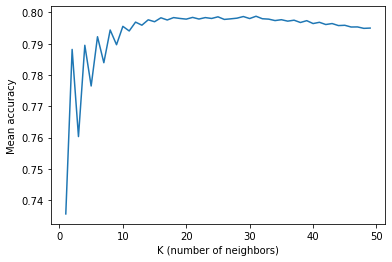

In [156]:
plt.plot(range(1,50), accuracy[1:])
plt.ylabel('Mean accuracy')
plt.xlabel('K (number of neighbors)')
plt.show()

### Prediction

In [173]:
#load test data
test = np.loadtxt('./adult.test', dtype=int, encoding='utf-8-sig', delimiter=', ', skiprows=1, converters=converters)
#seperate X and y of test data
y_test = test[:, -1]
X_test = np.delete(test, -1, axis=1)
#do one-hot-coding
X_test = one_hot_coding(X_test)
print('The shape of the testset is', test.shape)

The shape of the testset is (16281, 15)


In [177]:
#prediction
best_knn_model.fit(X_train, y_train)
y_pred = best_knn_model.predict(X_test)
acc = np.mean(y_pred == y_test)
print('The accuracy of KNN model with K=', best_K, 'is ', f'{acc:.4f}')

The accuracy of KNN model with K= 31 is  0.8027


<AxesSubplot:>

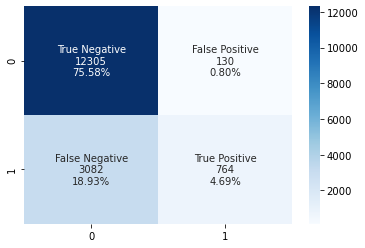

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

## Desicion Tree

### Use 5-fold cross-validation to pick the best parameters (max_depth, min_samples_leaf, min_impurity_decrease)

In [102]:
from sklearn.tree import DecisionTreeClassifier

#choices of hyperparameter 
max_depth_values = np.arange(5, 16)
min_samples_leaf_values = np.arange(10,40) * 2
min_impurity_decrease_values = np.arange(20) * 0.00002


total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
best_acc = 0
cur_per, count = -1, 0

#try all hyperparameter combinations
for max_depth in range(max_depth_values.size):
    for min_samples_leaf in  range(min_samples_leaf_values.size):
        for min_impurity_decrease in range(min_impurity_decrease_values.size):
            clf = DecisionTreeClassifier(max_depth=max_depth_values[max_depth], min_samples_leaf=min_samples_leaf_values[min_samples_leaf], min_impurity_decrease=min_impurity_decrease_values[min_impurity_decrease])
            #find the best 5-fold cross validation score accuracy
            acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
            accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
            if acc > best_acc:
                best_cfg = (max_depth_values[max_depth], min_samples_leaf_values[min_samples_leaf], min_impurity_decrease_values[min_impurity_decrease])
                best_acc = acc
                best_decistion_tree_model = clf

print(best_acc, best_cfg)


0.015151515151515152 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %
0.8547182197735619 (15, 20, 0.00018)


"\nplt.plot(range(2,31), accuracy[2:])\nplt.xlim(2,30)\nplt.ylim(0.75,0.86)\nplt.ylabel('Mean accuracy')\nplt.xlabel('max_depth')\nplt.show()\n"

### Visualize the best tree

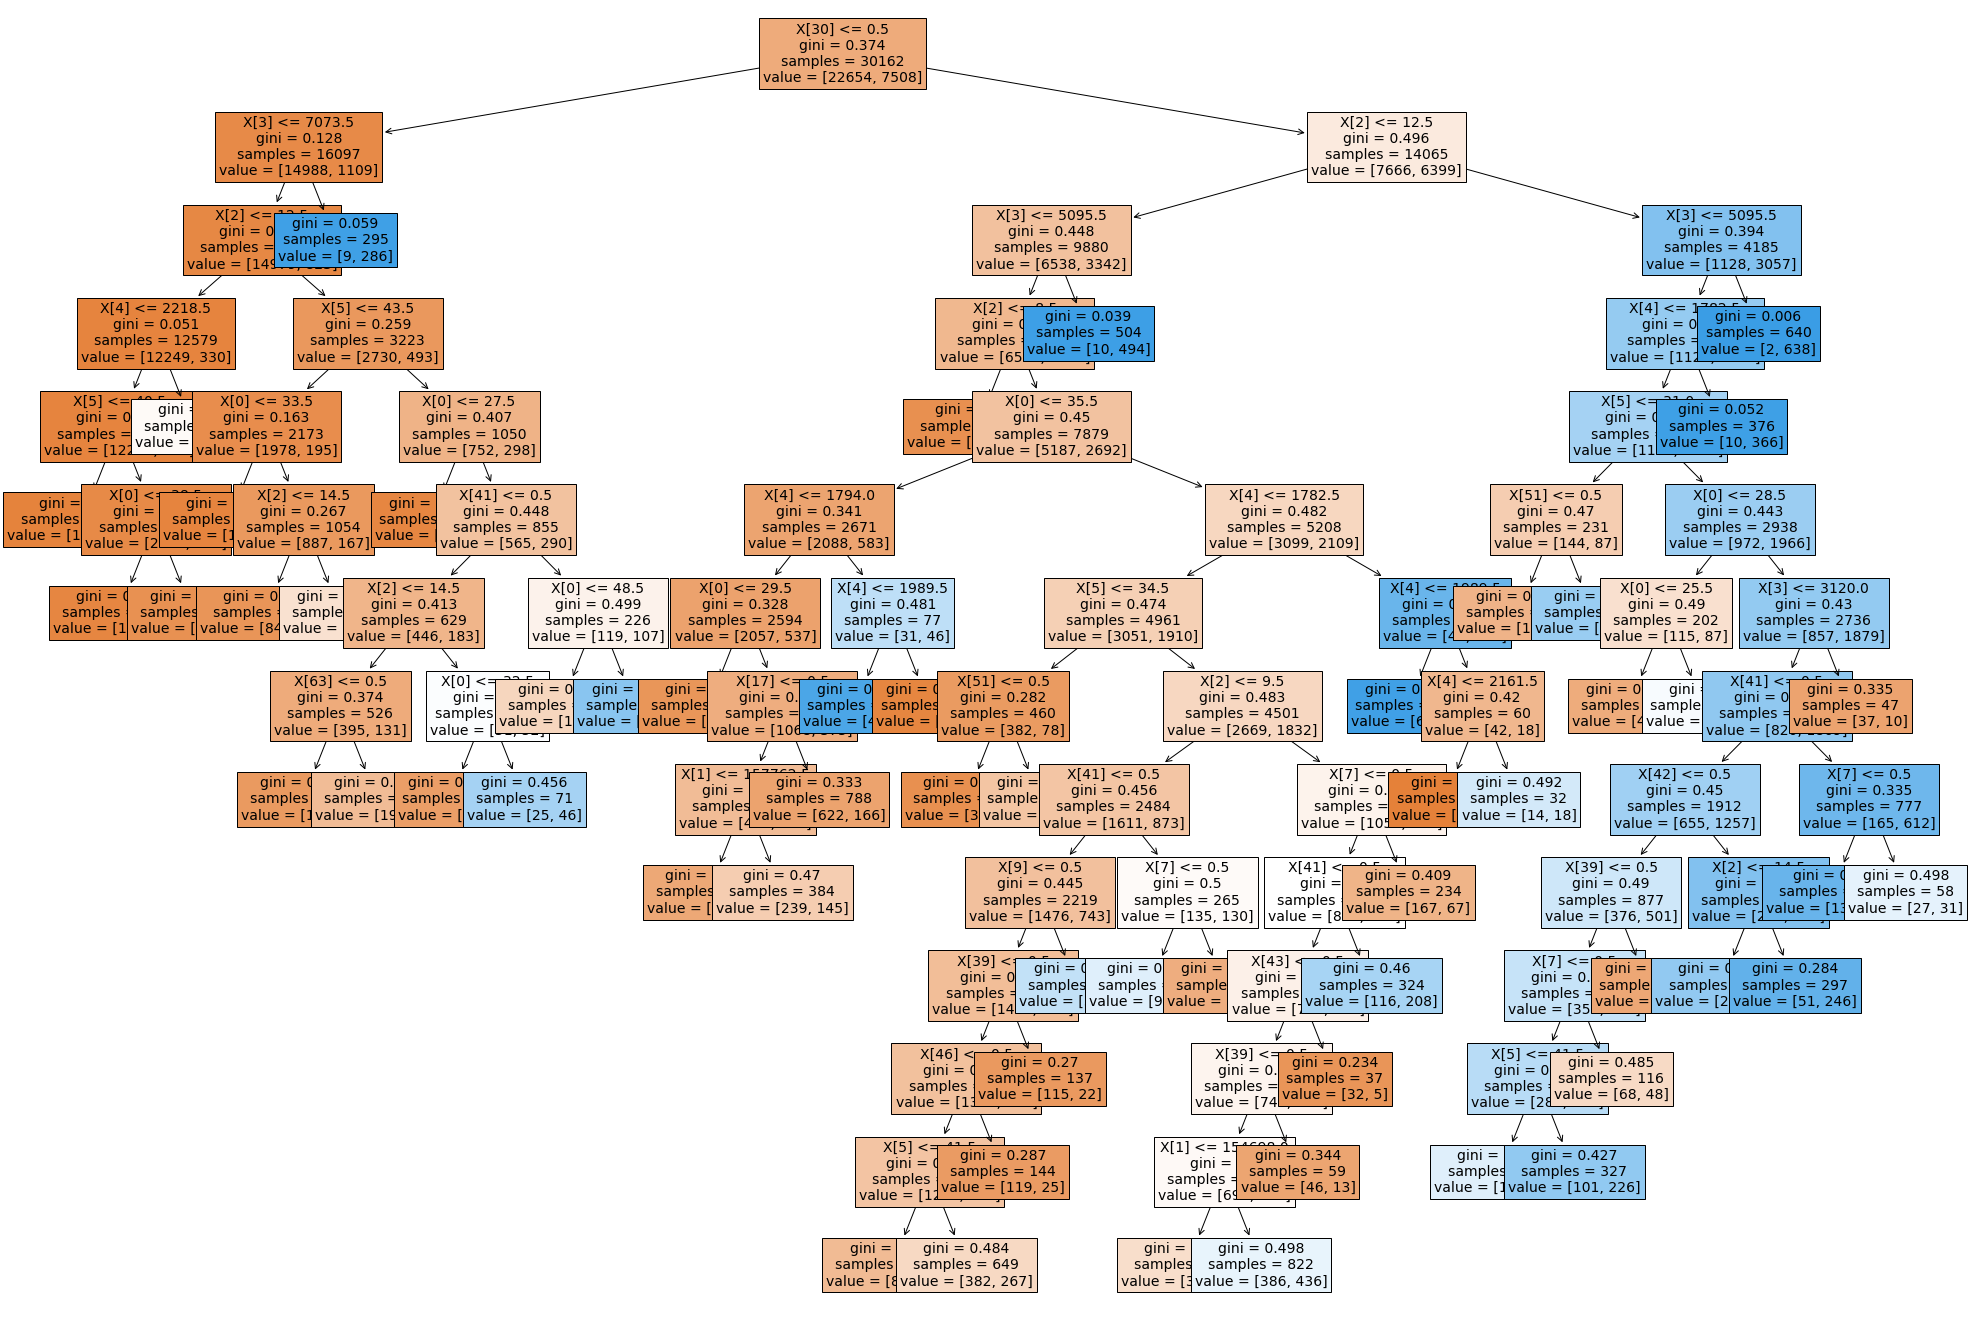

In [103]:
from sklearn.tree import plot_tree
best_model.fit(X_train, y_train)
plt.figure(figsize=(34,24))
plot_tree(best_model, filled=True, fontsize=14)
plt.show()

### Testing

In [131]:
y_pred = best_decistion_tree_model.predict(X_test)
acc = np.mean(y_pred == y_test)
print('accuracy = ', f'{acc:.4f}')


NotFittedError: ignored